## Estimate effect of guides from on-target knock-down

In [1]:
import rpy2.robjects.pandas2ri
import rpy2.robjects.numpy2ri

In [2]:
import os,sys
import numpy as np
import anndata
import pandas as pd
import mudata as md
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy

# Add the parent directory to the path to import from sibling directory
sys.path.append(os.path.abspath('../1_preprocess/'))
sys.path.append(os.path.abspath('../'))
from qc_plots import calculate_perturbed_gene_expression, test_knockdown_simple
from utils import feature_selection

## Load cell-level metadata with QC mask

In [8]:
datadir = '/mnt/oak/users/emma/data/GWT/CRiCD4_Run1_Illumina/'
experiment_name = 'CRiCD4_Run1_Illumina'
obs_df = pd.read_csv(f'{datadir}/{experiment_name}_merged.gex.lognorm.postQC_obs.csv', compression='gzip', index_col=0)

## Test guide knockdown efficacy

- Find guides with sufficient cells per replicate (at least 3 cells in the same replicate & condition)
- Test on-target knockdown efficiency in those guides with t-test
- Classify high and low confidence knockdown calls based on number of perturbed cells and baseline expression (assuming that absence of evidence of knockdown with few cells and on lowly expressed genes in not evidence of absence)

In [ ]:
guide_cell_counts = obs_df[['perturbed_gene_name', 'guide_id', 'library_id', 'culture_condition']].value_counts().reset_index()

# Mark guides with at least 3 cells per condition & sample
guide_cell_counts = guide_cell_counts[~guide_cell_counts['guide_id'].str.startswith('NTC-')]
guide_cell_counts['pass_filter'] = guide_cell_counts['count'] >= 5
guide_cell_counts.head()

# Count number of cells per guide in each condition
guides_n_cells = guide_cell_counts.groupby(['guide_id', 'culture_condition'])['count'].sum()\
    .sort_values()\
    .reset_index()\
    .pivot(index='guide_id', columns='culture_condition', values='count')\
    .fillna(0)

# Count number of replicates per guide in each condition
guides_replicates = guide_cell_counts.groupby(['guide_id', 'culture_condition'])['pass_filter'].sum()\
    .sort_values()\
    .reset_index()\
    .pivot(index='guide_id', columns='culture_condition', values='pass_filter')\
    .fillna(0)

guides_replicates['total_replicates'] = guides_replicates.sum(1) 
guides_replicates = guides_replicates.sort_values('total_replicates', ascending=False)
guides_replicates.head()

culture_condition,Rest,Stim8hr,total_replicates
guide_id,,,
SERPINE1-1,2.0,2.0,4.0
HPSE-2,2.0,2.0,4.0
CXCR5-2,2.0,2.0,4.0
HRAS-2,2.0,2.0,4.0
CXCR4-2,2.0,2.0,4.0


In [ ]:
filter_guides = guides_replicates[guides_replicates['total_replicates'] == 0].index.tolist()
filter_guides_mask = ~adata.obs['guide_id'].isin(filter_guides)

adata = sc.read_h5ad(f'{datadir}/{experiment_name}_merged.gex.lognorm.h5ad', backed=True)
adata.obs = obs_df.copy()
adata = adata[adata.obs['QC_mask'] & (adata.obs['guide_id'] != 'multi_sgRNA') & filter_guides_mask].to_memory()

In [ ]:
from tqdm.notebook import tqdm
count_perturbed_genes = adata.obs['perturbed_gene_name'].value_counts()[1:]
test_perturbed_genes = count_perturbed_genes.index
# Split the perturbed genes into groups of 100
test_perturbed_genes_list = [test_perturbed_genes[i:i+100] for i in range(0, len(test_perturbed_genes), 100)]

all_perturbed_gene_expr_df = pd.DataFrame()

for t_genes in tqdm(test_perturbed_genes_list, desc="Processing gene groups"):
    t_genes = t_genes.to_list()
    perturbed_gene_expr_df = calculate_perturbed_gene_expression(adata[adata.obs['perturbed_gene_name'].isin(t_genes + ['NTC'])])
    perturbed_gene_expr_df['guide_id'] = adata[adata.obs['perturbed_gene_name'].isin(t_genes + ['NTC'])].obs['guide_id']
    perturbed_gene_expr_df = perturbed_gene_expr_df.drop('perturbed_gene', axis=1).dropna()
    # kd_results_c = test_knockdown_simple(perturbed_gene_expr_df, group_col='guide_id')
    all_perturbed_gene_expr_df = pd.concat([all_perturbed_gene_expr_df, perturbed_gene_expr_df])

Processing gene groups:   0%|          | 0/112 [00:00<?, ?it/s]

/mnt/oak/users/emma/bin/GWT_perturbseq_analysis/src/1_preprocess/qc_plots.py:77: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[perturbed_gene_col + '_test'] = adata.obs[perturbed_gene_col].copy()
/mnt/oak/users/emma/bin/GWT_perturbseq_analysis/src/1_preprocess/qc_plots.py:77: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[perturbed_gene_col + '_test'] = adata.obs[perturbed_gene_col].copy()
/mnt/oak/users/emma/bin/GWT_perturbseq_analysis/src/1_preprocess/qc_plots.py:77: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[perturbed_gene_col + '_test'] = adata.obs[perturbed_gene_col].copy()
/mnt/oak/users/emma/bin/GWT_perturbseq_analysis/src/1_preprocess/qc_plots.py:77: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[perturbed_gene_co

In [ ]:
ntc_expr_thresh = 0.1 # min mean expression in NTCs to call ineffective guide
n_perturbed_cells_thresh = 10 # min number of perturbed cells to call ineffective guide

all_conditions = adata.obs['culture_condition'].unique()

all_kd_results = pd.DataFrame()
for cond in all_conditions:
    kd_results_stim = test_knockdown_simple(all_perturbed_gene_expr_df[all_perturbed_gene_expr_df.index.str.contains(cond)], group_col='guide_id')

    # Annotate confidence in kd call
    kd_results_stim['low_confidence_kd_call'] = (kd_results_stim['perturbed_gene_mean_ntc'] <= ntc_expr_thresh) | \
        (kd_results_stim['n_perturbed_cells'] <= n_perturbed_cells_thresh) | \
        (kd_results_stim['t_statistic'] < -1)
    kd_results_stim['culture_condition'] = cond
    all_kd_results = pd.concat([all_kd_results, kd_results_stim])

In [ ]:
# Store
all_kd_results.to_csv(datadir + 'guide_ontarget_effect_simple.csv')

In [4]:
all_kd_results = pd.read_csv(datadir + 'guide_ontarget_effect_simple.csv')

### Visualize high confidence ineffective guides

In [5]:
def plot_kd(mean_perturbed_gene_expr_df, top_n=100, figsize=(15,6), show_xlabels=True):
    # Group by guide_id instead of perturbed_gene
    guide_means = mean_perturbed_gene_expr_df.copy()

    # Select a subset of guides to plot (to avoid overcrowding)
    pl_df = guide_means.head(top_n)  # Take first 100 guides or adjust as needed
    pl_df
    plt.figure(figsize=figsize)
    # Plot mean NTC expression with error bars
    plt.errorbar(pl_df['guide_id'],
                pl_df['perturbed_gene_mean_ntc'], 
                yerr=pl_df['perturbed_gene_std_ntc'],
                fmt='o',
                color='grey',
                markersize=2,
                alpha=0.5,
                label='NT control cells')

    # Add stripplot of perturbed expression
    plt.errorbar(pl_df['guide_id'],
            pl_df['perturbed_gene_expr'],
            yerr=pl_df['perturbed_gene_expr_std'],
            fmt='o',
            markersize=2,
            color='blue',
            alpha=0.5,
            label='Perturbed cells')

    if show_xlabels:
        plt.xticks(rotation=90)
    else:
        plt.xticks([])
    plt.ylim(0)
    plt.xlabel('Guide ID')
    plt.ylabel('Perturbed gene expression (log-normalized counts)')
    plt.title('Non-significant knockdowns by guide')
    plt.legend(frameon=False)
    plt.tight_layout()

In [6]:
all_kd_results.value_counts(['signif_knockdown', 'low_confidence_kd_call'])

signif_knockdown  low_confidence_kd_call
True              True                      27477
False             True                       6521
                  False                      1366
Name: count, dtype: int64

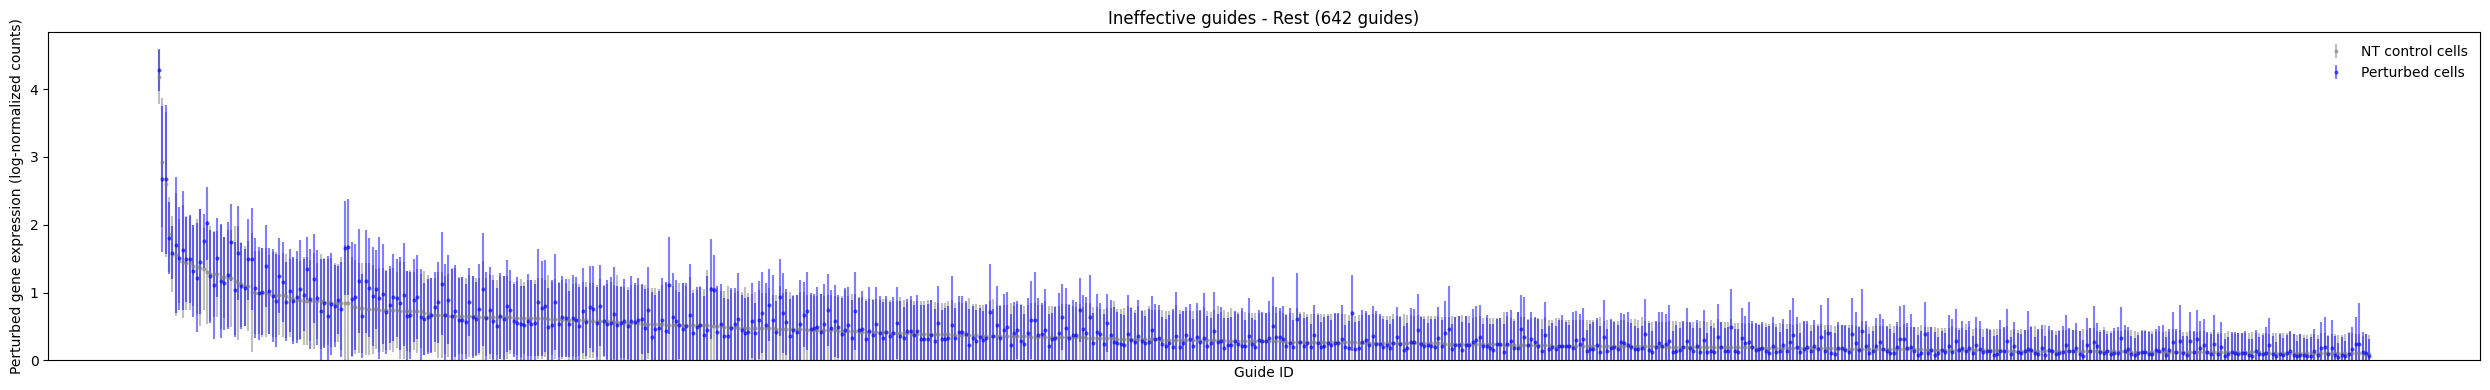

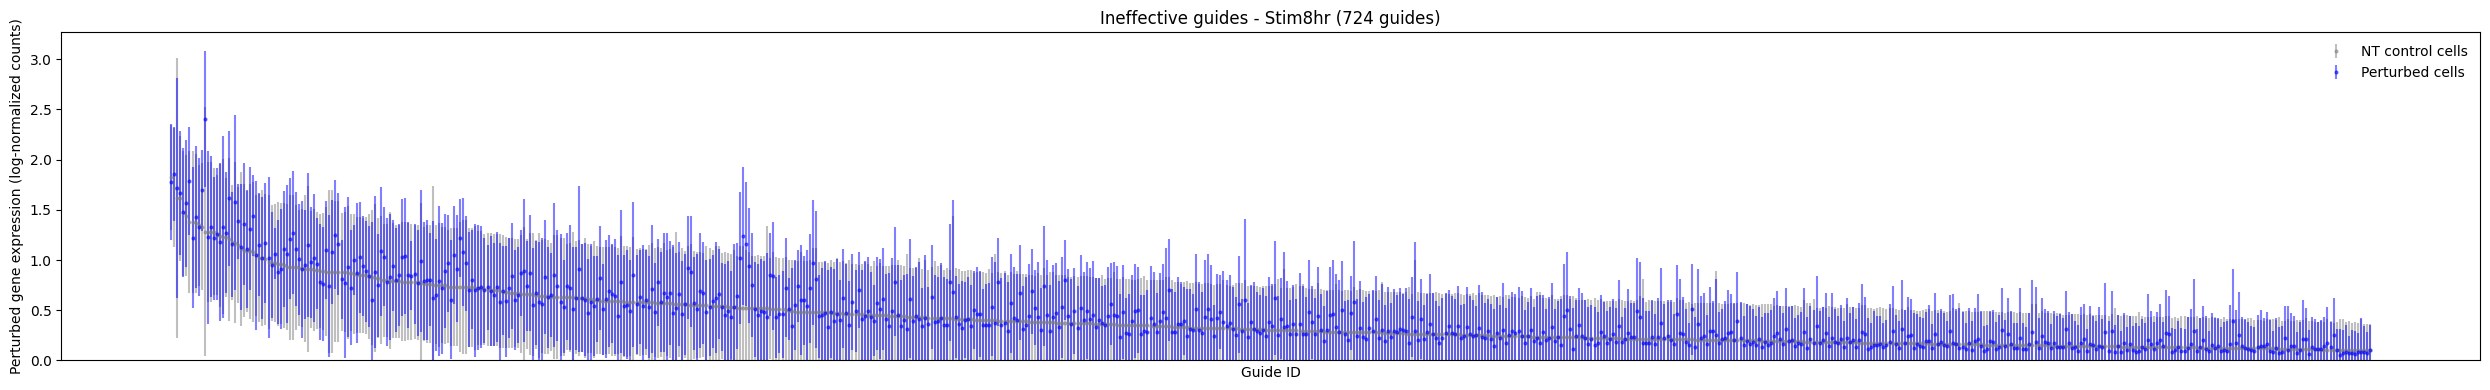

In [12]:
for cond in all_kd_results.culture_condition.unique():
    pl_df = all_kd_results[
        (~all_kd_results['signif_knockdown']) & 
        (~all_kd_results['low_confidence_kd_call']) & 
        (all_kd_results['culture_condition'] == cond)].sort_values('perturbed_gene_mean_ntc', ascending=False)
    plot_kd(pl_df, top_n=1100, show_xlabels=False, figsize=(25,4));
    plt.title(f'Ineffective guides - {cond} ({pl_df.shape[0]} guides)')
    plt.show()


### Save list of putative ineffective guides (across conditions)

In [13]:
# Classify if no effect in both condition and high confidence in at least one condition
all_kd_results['bad_guide'] = (~all_kd_results['signif_knockdown']) & (~all_kd_results['low_confidence_kd_call'])
n_high_confidence_bad = all_kd_results.pivot(index='guide_id', columns='culture_condition', values='bad_guide').fillna(False).sum(1)
n_signif = all_kd_results.pivot(index='guide_id', columns='culture_condition', values='signif_knockdown').fillna(False).sum(1)

no_effect_guides = n_signif.index[(n_signif == 0) & (n_high_confidence_bad >= 1)].tolist()

# Save no_effect_guides to a text file
with open(os.path.join(datadir, 'no_effect_guides.txt'), 'w') as f:
    for guide in no_effect_guides:
        f.write(f"{guide}\n")


/tmp/ipykernel_3878958/3196087050.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  n_high_confidence_bad = all_kd_results.pivot(index='guide_id', columns='culture_condition', values='bad_guide').fillna(False).sum(1)
/tmp/ipykernel_3878958/3196087050.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  n_signif = all_kd_results.pivot(index='guide_id', columns='culture_condition', values='signif_knockdown').fillna(False).sum(1)


In [14]:
len(no_effect_guides)

533